In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

# Module 11 Lab - Model Evaluation

## Directions

1. Show all work/steps/calculations using Code and Markdown cells.
2. Submit your notebook (.ipynb).
3. You may use any core Python libraries or Numpy/Scipy. **Additionally, code from the Module notebooks and lectures is fair to use and modify.** You may also consult Stackoverflow (SO). If you use something from SO, please place a comment with the URL to document the code.

In [96]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import patsy
import sklearn.linear_model as linear

sns.set(style="whitegrid")
# load whatever other libraries you need including models.py
import models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.model_selection import KFold
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from collections import defaultdict

## Model Evaluation and Improvement

As we saw in both the Linear Regression and Logistic Regression modules, there is a Statistician's view of Model Evaluation (and perhaps, Improvement) and a Machine Learning view of Model Evaluation and Improvement.

We'll be working with the insurance data.

**1. Load the data, perform your transformations, and using the Bootstrap version of the Linear Regression function, estimate your final model from Lab 10 and show the Bootstrap results**

In [5]:
insurance = pd.read_csv('insurance.csv')

In [26]:
insurance2.head()

,age,bmi,children,charges,age_sq,bmi_above_30,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest,smoker_no,smoker_yes
0,19,27.900,0,16884.92400,361,0,1,0,0,0,0,1,0,1
1,18,33.770,1,1725.55230,324,1,0,1,0,0,1,0,1,0
2,28,33.000,3,4449.46200,784,1,0,1,0,0,1,0,1,0
3,33,22.705,0,21984.47061,1089,0,0,1,0,1,0,0,1,0
4,32,28.880,0,3866.85520,1024,0,0,1,0,1,0,0,1,0


In [13]:
insurance['age_sq'] = insurance['age']**2
insurance['bmi_above_30'] = insurance.bmi.apply(lambda bmi: 1 if bmi > 30.0 else 0)

In [14]:
insurance2 = pd.get_dummies(insurance,columns=["sex",'region','smoker'])

In [30]:
insurance2['smoker_and_bmi'] = insurance2['smoker_yes'] * insurance2['bmi']
insurance2['smoker_and_bmi_above_30'] = insurance2['smoker_yes'] * insurance2['bmi_above_30']

In [78]:
np.random.seed(11223)
model = "charges ~ age_sq + sex_male + bmi + smoker_yes + smoker_yes:bmi + smoker_yes:bmi_above_30 + children"
final = models.bootstrap_linear_regression(model, data=insurance2)
models.describe_bootstrap_lr(final)

**2. Perform three rounds of 10-fold cross validation, estimating $R^2$ and $\sigma$ each round. Using the results for the test data, calculate 95% Bootstrap estimates of the credible intervals for each.** Comment on these intervals and the intervals from above. Are the average values different? Are the intervals different?

In [84]:
## some code taken from https://scikit-learn.org/stable/modules/cross_validation.html
r2 = []
sigma = []
clf = LinearRegression()
np.random.seed(11224)
kf = KFold(n_splits = 10)
for i in range(3):
    insurance_random = insurance2.sample(frac=1)
    X = insurance_random[['age_sq','sex_male','bmi','smoker_yes','smoker_and_bmi','smoker_and_bmi_above_30','children']]
    y = insurance_random[['charges']]
    for train_index,test_index in kf.split(X):
        X_train, X_test, y_train, y_test = X.iloc[train_index,:], X.iloc[test_index,:], y.iloc[train_index,:], y.iloc[test_index,:]
        clf.fit(X_train,y_train)
        r2.append(clf.score(X_test,y_test))
        sigma.append(np.sqrt(mean_squared_error(y_test,clf.predict(X_test))))

In [85]:
np.mean(sigma)

4344.842332988241

In [87]:
stats.mstats.mquantiles( sigma, [0.05, 0.95])

array([3447.68026489, 5357.46633358])

In [86]:
np.mean(r2)

0.8646699087813502

In [88]:
stats.mstats.mquantiles( r2, [0.05, 0.95])

array([0.76170671, 0.92008367])

In [42]:
best_svr = svm.SVR(kernel='rbf')
cross_val_score(best_svr, X, y, cv=10)

array([-0.13643404, -0.09737471, -0.14874846, -0.07066836, -0.10689846,
       -0.05972867, -0.07512315, -0.14948728, -0.11545837, -0.10047127])

It looks like the mean is approximately the same, but the 90% interval is a lot larger.

**3. Using Learning Curves and $\sigma$ determine if more data will improve the estimation of the model.**

In [111]:
def mse( errors):
    n = len( errors)
    squared_error = np.sum( [e**2 for e in errors])
    return np.sqrt((1.0/n) * squared_error)


In [109]:
from copy import deepcopy

def cross_validate( formula, data, test_size=0.20):
    training_mses = []
    test_mses = []
    
    n = data.shape[ 0]
    test_n = int( np.round( test_size * n, 0))

    indices = deepcopy( data.index).values
    random.shuffle( indices)

    test_indices = indices[ 0:test_n]
    training_indices = indices[test_n:]

    test_set = data.ix[ test_indices]
    training_set = data.ix[ training_indices]

    y, X = patsy.dmatrices( formula, training_set, return_type="matrix")
    model = linear.LinearRegression( fit_intercept=False).fit( X, y)
    y_hat = model.predict( X)

    training_mse = mse( y - y_hat)

    y, X = patsy.dmatrices( formula, test_set, return_type="matrix")
    y_hat = model.predict( X)

    test_mse = mse( y - y_hat)

    return training_mse, test_mse

In [107]:
def learning_curve( formula, data, increment=0.05, iterations=100, test_size=0.20):
    increments = int( 1.0/increment)
    chunks = [ int(x) for x in np.linspace( 0, data.shape[ 0], increments)][ 1:]
    train = []
    test = []
    for chunk in chunks:
        train_chunk = []
        test_chunk = []
        for i in range( iterations):
            indices = list(range( data.shape[ 0]))
            random.shuffle( indices)
            chunk_indices = indices[0:chunk]
            data_chunk = data.ix[ chunk_indices]
            train_mse, test_mse = cross_validate( formula, data_chunk, test_size=test_size)
            train_chunk.append( train_mse)
            test_chunk.append( test_mse)
        train.append( np.mean( train_chunk))
        test.append( np.mean( test_chunk))
    return chunks, train, test

In [112]:
chunks, train, test = learning_curve(model, insurance2, increment = .01) 

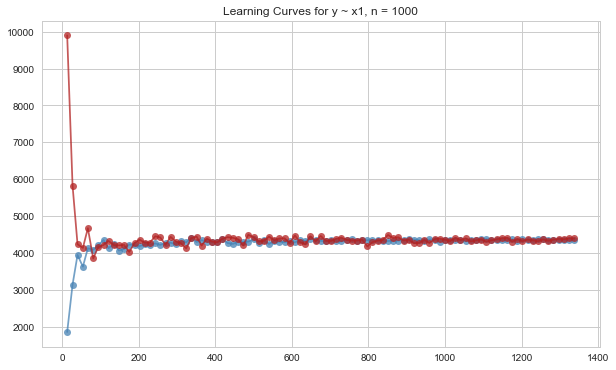

In [114]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

axes.plot( chunks, train, 'o-', color="steelblue", alpha=0.75)
axes.plot( chunks, test, "o-", color="firebrick", alpha=0.75)

axes.set_title( "Learning Curves for y ~ x1, n = 1000")


plt.show()
plt.close()

Based on what I can see, it does not look like adding additional data will help. 

**4. It was shown that `age_sq` improved the performance of the model. Perhaps a different polynomial would have been better. Generate Validation Curves for `age` = [1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5] and select the best transformation.**

In [113]:
def validation_curves( formulas, data, iterations=100, test_size=0.2):
    train = []
    test = []
    for formula in formulas:
        train_chunk = []
        test_chunk = []
        for i in range( iterations):
            train_mse, test_mse = cross_validate( formula, data, test_size=test_size)
            train_chunk.append( train_mse)
            test_chunk.append( test_mse)
        train.append( np.mean( train_chunk))
        test.append( np.mean( test_chunk))
    print(train)
    print(test)
    return train, test

In [128]:
train_list=[]
test_list =[]
np.random.seed(11125)
for i in np.linspace(1.5,2.5,11):
    insurance2['age_transform'] = insurance2['age']**i
    train_temp, test_temp = validation_curves(['charges ~ age_transform'],insurance2)
    train_list = train_list + train_temp
    test_list = test_list + test_temp

[11543.39116545222]
[11536.442121478183]
[11534.357412079156]
[11574.872012276162]
[11557.912674022878]
[11484.23747070641]
[11524.640442036318]
[11618.105973458127]
[11550.101462953417]
[11512.262169100262]
[11591.215523489944]
[11349.365447438]
[11511.620152099465]
[11667.569283378405]
[11544.563054632636]
[11541.266042271136]
[11523.375299012754]
[11627.535887534263]
[11565.281365072942]
[11471.169847360801]
[11575.605755586703]
[11441.303366629512]


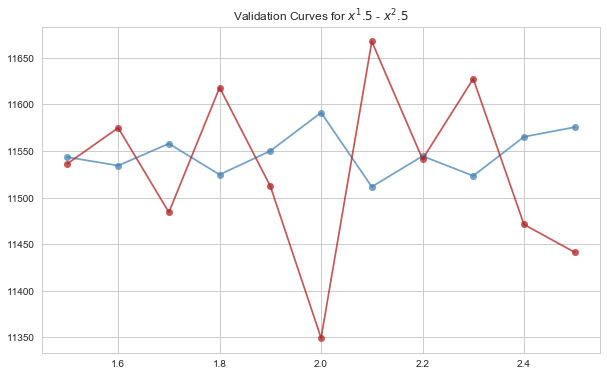

In [133]:
xs = np.linspace(1.5,2.5,11)
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

axes.plot( xs, train_list, 'o-', color="steelblue", alpha=0.75)
axes.plot( xs, test_list, "o-", color="firebrick", alpha=0.75)
#axes.set_xticks(xs)
#axes.set_xticklabels(xs)

axes.set_title( "Validation Curves for $x^1.5$ - $x^2.5$")

plt.show()
plt.close()

It looks a little noisy, but I seems the least biased and least variance point is around age^(2.2). But the test has the lowest error at 2.0, which might be due to just noise

**5. Using Ridge Regression to estimate a model for the insurance data. Compare it with your final Linear Regression model.** (If you get far ahead, you may need to write your own function. Here are the sklearn docs: http://scikit-learn.org/stable/modules/linear_model.html)

In [134]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha=.5)
reg.fit(X,y)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [135]:
reg.coef_

array([[ 3.34478378e+00, -5.15927086e+02,  3.13879697e+00,
         1.07747274e+03,  4.88216339e+02,  1.48813911e+04,
         6.51408661e+02]])

In [136]:
reg.intercept_

array([2027.83866314])

In [138]:
final['coefficients']

array([ 2.01487513e+03,  3.34469600e+00, -5.16741115e+02,  3.56104037e+00,
        1.63298426e+03,  4.64318204e+02,  1.52255672e+04,  6.51467166e+02])

It appears that the intercepts are close, and that most of the betas are very close to each other. The largest difference is the 4th one, which appears to have been "smoker yes"

## Appendix code from lecture pdf

In [92]:
def sse(results):
    errors = results['residuals']
    n = len( errors)
    squared_error = np.sum( [e**2 for e in errors])
    return np.sqrt((1.0/n) * squared_error)


In [94]:
def data_collection():
    result = dict()
    result[ "train"] = defaultdict( list)
    result[ "test"] = defaultdict( list)
    return result

In [99]:
def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]


In [97]:
def learning_curves(algorithm, formula, data, evaluate, fold_count=10, repetitions=3,
    increment=1):
    indices = list(range(len( data)))
    results = data_collection()
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i in list(range(increment, 100, increment)) + [100]: # ensures 100% is always picked.
                # the indices are already shuffled so we only need to take everincreasing chunks
                train_chunk_size = int( np.ceil((i/100)*len( train_indices)))
                train_data_chunk = data.iloc[train_indices[0:train_chunk_size]]
                # we calculate the model
                result = algorithm(formula, data=train_data_chunk)
                model = result["model"]
                # we calculate the results for the training data subset
                y, X = patsy.dmatrices( formula, train_data_chunk, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["train"][i].append( metric)
                # we calculate the results for the test data.
                y, X = patsy.dmatrices( formula, test_data, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["test"][i].append( metric)
    #
    #
    # process results
    # Rely on the CLT...
    statistics = {}
    for k, v in results["train"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["train"] = statistics
    statistics = {}
    for k, v in results["test"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["test"] = statistics
    return results
    #